In [ ]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

### Load training and Validation arrays

In [ ]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3,
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [ ]:
npzfile = np.load('../input/load-data1/shuffled_train.npz.npz（副本）')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394, 8)


In [ ]:
npzfile = np.load('../input/load-data1/shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800, 8)


In [ ]:
X_train_list = []
y_train_list = []
for i,j in zip(X_train,y_train):
    X_train_list.append(i[0:128])
    X_train_list.append(i[128:256])
    X_train_list.append(i[256:384])
    X_train_list.append(i[384:512])
    X_train_list.append(i[512:])
    y_train_list.append(j)
    y_train_list.append(j)
    y_train_list.append(j)
    y_train_list.append(j)
    y_train_list.append(j)

In [ ]:
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_train.shape,y_train.shape

((31970, 128, 128), (31970, 8))

In [ ]:
del X_train_list,y_train_list
import gc
gc.collect()

567

In [ ]:
X_valid_list = []
y_valid_list = []
for i,j in zip(X_valid,y_valid):
    X_valid_list.append(i[0:128])
    X_valid_list.append(i[128:256])
    X_valid_list.append(i[256:384])
    X_valid_list.append(i[384:512])
    X_valid_list.append(i[512:])
    y_valid_list.append(j)
    y_valid_list.append(j)
    y_valid_list.append(j)
    y_valid_list.append(j)
    y_valid_list.append(j)
X_valid = np.array(X_valid_list)
y_valid = np.array(y_valid_list)
X_valid.shape,y_valid.shape

del X_valid_list,y_valid_list
import gc
gc.collect()

23

### Check by plotting a Spectogram

Folk


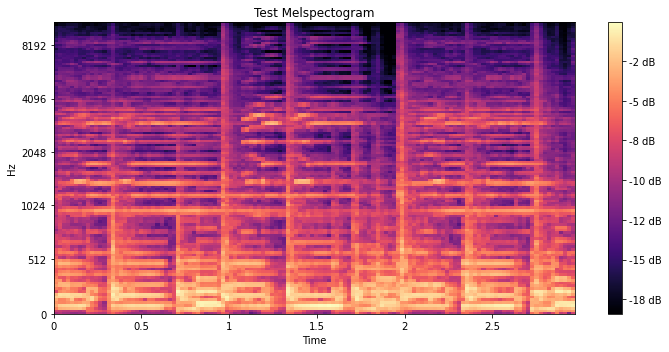

In [ ]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## moded

In [ ]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

from tensorflow.keras import backend as K
K.clear_session()

BATCH_SIZE = 64
EPOCH_COUNT = 50
L2_regularization = 0.001

### MobileNetV3

In [ ]:
MobileNetV3 = tf.keras.applications.MobileNetV3Small

input_shape = (128,128, 1)
model_input = Input(input_shape, name='input')

input_layer =tf.keras.layers.Concatenate(axis=3)([model_input, model_input,model_input])


inc_model = MobileNetV3(include_top=False)(input_layer)

#Adding custom Layers
# x = inc_model.output
x = GlobalAveragePooling2D()(inc_model)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(8, activation="softmax")(x)

# creating the final model
model = Model(inputs=model_input, outputs=predictions)

# Lock initial layers to do not be trained
# for layer in model.layers[:20]:
#     layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

6709248/6698480 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5',
                               verbose=1, save_best_only=True)

history = model.fit(X_train, y_train,
                              batch_size=8,
                              epochs=EPOCH_COUNT,
                              validation_data=(X_valid, y_valid),
                              callbacks=[checkpointer],
                              verbose=1
                    )

Epoch 1/50
3997/3997 [==============================] - 100s 22ms/step - loss: 1.6252 - accuracy: 0.4125 - val_loss: 1.8616 - val_accuracy: 0.3453

Epoch 00001: val_loss improved from inf to 1.86158, saving model to weights.best.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
3997/3997 [==============================] - 85s 21ms/step - loss: 1.3826 - accuracy: 0.5130 - val_loss: 1.4478 - val_accuracy: 0.4840

Epoch 00002: val_loss improved from 1.86158 to 1.44777, saving model to weights.best.hdf5
Epoch 3/50
3997/3997 [==============================] - 85s 21ms/step - loss: 1.2453 - accuracy: 0.5617 - val_loss: 1.4383 - val_accuracy: 0.4958

Epoch 00003: val_loss improved from 1.44777 to 1.43830, saving model to weights.best.hdf5
Epoch 4/50
3997/3997 [==============================] - 87s 22ms/step - loss: 1.1431 - accuracy: 0.5954 - val_loss: 1.4477 - val_accuracy: 0.5325

Epoch 00004: val_loss did not improve from 1.43830
Epoch 5/50
3997/3997 [==============================] - 86s 21ms/step - loss: 1.0476 - accuracy: 0.6309 - val_loss: 1.7292 - val_accuracy: 0.4078

Epoch 00005: val_loss did not improve from 1.43830
Epoch 6/50
3997/3997 [==============================] - 85s 21ms/step - loss: 0.9549 - accuracy: 0.6619 - val_loss: 1.6256 - val_a

### ShuffleNet

In [ ]:
# !pip install keras_applications

In [ ]:
# import numpy as np
# from tensorflow.keras.utils import plot_model
# from keras_applications.imagenet_utils import _obtain_input_shape
# from tensorflow.keras.utils import get_source_inputs
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
# from tensorflow.keras.layers import Activation, Dense
# from tensorflow.keras.models import Model
# import keras.backend as K
# from shutil import copyfile

# # copy our file into the working directory (make sure it has .py suffix)
# copyfile(src = "../input/utils/utils2.py", dst = "../working/utils2.py")

# from utils2 import block

In [ ]:
# def ShuffleNetV2(include_top=True,
#                  input_tensor=None,
#                  scale_factor=1.0,
#                  pooling='max',
#                  input_shape=(224,224,3),
#                  load_model=None,
#                  num_shuffle_units=[3,7,3],
#                  bottleneck_ratio=1,
#                  classes=1000):
#     if K.backend() != 'tensorflow':
#         raise RuntimeError('Only tensorflow supported for now')
#     name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
#     input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
#                                       data_format=K.image_data_format())
#     out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

#     if pooling not in ['max', 'avg']:
#         raise ValueError('Invalid value for pooling')
#     if not (float(scale_factor)*4).is_integer():
#         raise ValueError('Invalid value for scale_factor, should be x over 4')
#     exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
#     out_channels_in_stage = 2**exp
#     out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
#     out_channels_in_stage[0] = 24  # first stage has always 24 output channels
#     out_channels_in_stage *= scale_factor
#     out_channels_in_stage = out_channels_in_stage.astype(int)

#     if input_tensor is None:
#         img_input = Input(shape=input_shape)
#     else:
#         if not K.is_keras_tensor(input_tensor):
#             img_input = Input(tensor=input_tensor, shape=input_shape)
#         else:
#             img_input = input_tensor

#     # create shufflenet architecture
#     x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
#                activation='relu', name='conv1')(img_input)
#     x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

#     # create stages containing shufflenet units beginning at stage 2
#     for stage in range(len(num_shuffle_units)):
#         repeat = num_shuffle_units[stage]
#         x = block(x, out_channels_in_stage,
#                    repeat=repeat,
#                    bottleneck_ratio=bottleneck_ratio,
#                    stage=stage + 2)

#     if bottleneck_ratio < 2:
#         k = 1024
#     else:
#         k = 2048
#     x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

#     if pooling == 'avg':
#         x = GlobalAveragePooling2D(name='global_avg_pool')(x)
#     elif pooling == 'max':
#         x = GlobalMaxPooling2D(name='global_max_pool')(x)

#     if include_top:
#         x = Dense(classes, name='fc')(x)
#         x = Activation('softmax', name='softmax')(x)

#     if input_tensor:
#         inputs = get_source_inputs(input_tensor)

#     else:
#         inputs = img_input

#     model = Model(inputs, x, name=name)

#     if load_model:
#         model.load_weights('', by_name=True)

#     return model

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
# input_shape = (128,128, 1)
# model_input = Input(input_shape, name='input')

# input_layer =tf.keras.layers.Concatenate(axis=3)([model_input, model_input,model_input])


# inc_model = ShuffleNetV2(include_top=False, input_shape=(128,128, 3),load_model=None, classes=8)(input_layer)
# #Adding custom Layers
# # x = inc_model.output
# #x = GlobalAveragePooling2D()(inc_model)
# x = Dense(1024, activation="relu")(inc_model)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# predictions = Dense(8, activation="softmax")(x)

# # creating the final model
# model = Model(inputs=model_input, outputs=predictions)

# #Lock initial layers to do not be trained
# # for layer in model.layers[:50]:
# #     layer.trainable = False

# model.compile(optimizer=Adam(lr=0.0001)
#                     , loss='categorical_crossentropy'
#                     , metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# checkpointer = ModelCheckpoint(filepath='weights.best.hdf5',
#                                verbose=1, save_best_only=True)

# history = model.fit(X_train, y_train,
#                               batch_size=8,
#                               epochs=EPOCH_COUNT,
#                               validation_data=(X_valid, y_valid),
#                               callbacks=[checkpointer],
#                               verbose=1
#                     )

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

### efficientnetv2

In [ ]:
# !pip install -U git+https://github.com/leondgarse/keras_efficientnet_v2

In [ ]:
# import keras_efficientnet_v2
# import tensorflow as tf

# input_shape = (640,128, 1)
# model_input = Input(input_shape, name='input')

# input_layer =tf.keras.layers.Concatenate(axis=3)([model_input, model_input,model_input])


# inc_model = keras_efficientnet_v2.EfficientNetV2B0(input_shape=(None, None, 3),drop_connect_rate=0.5, num_classes=0, pretrained="imagenet21k-ft1k")(input_layer)

# #Adding custom Layers
# # x = inc_model.output
# x = GlobalAveragePooling2D()(inc_model)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# predictions = Dense(8, activation="softmax")(x)

# # creating the final model
# model = Model(inputs=model_input, outputs=predictions)

# #Lock initial layers to do not be trained
# # for layer in model.layers[:50]:
# #     layer.trainable = False

# model.compile(optimizer=Adam(lr=0.0001)
#                     , loss='categorical_crossentropy'
#                     , metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# checkpointer = ModelCheckpoint(filepath='weights.best.hdf5',
#                                verbose=1, save_best_only=True)

# history = model.fit(X_train, y_train,
#                               batch_size=BATCH_SIZE,
#                               epochs=EPOCH_COUNT,
#                               validation_data=(X_valid, y_valid),
#                               callbacks=[checkpointer],
#                               verbose=1
#                     )

bset 0.6313

In [ ]:
# nb_filters1=16
# nb_filters2=32
# nb_filters3=64
# nb_filters4=64
# nb_filters5=64
# ksize = (3,1)p'
# pool_size_1= (2,2)
# pool_size_2= (4,4)
# pool_size_3 = (4,2)

# dropout_prob = 0.20
# dense_size1 = 128
# lstm_count = 64
# num_units = 120

# BATCH_SIZE = 64
# EPOCH_COUNT = 50
# L2_regularization = 0.001

# def conv_recurrent_model_build(model_input):
#     print('Building model...')
#     layer = model_input

#     ### Convolutional blocks
#     conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_1')(layer)
#     pool_1 = MaxPooling2D(pool_size_1)(conv_1)

#     conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_2')(pool_1)
#     pool_2 = MaxPooling2D(pool_size_1)(conv_2)

#     conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_3')(pool_2)
#     pool_3 = MaxPooling2D(pool_size_1)(conv_3)


#     conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_4')(pool_3)
#     pool_4 = MaxPooling2D(pool_size_2)(conv_4)


#     conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_5')(pool_4)
#     pool_5 = MaxPooling2D(pool_size_2)(conv_5)

#     flatten1 = Flatten()(pool_5)
#     ### Recurrent Block

#     # Pooling layer
#     pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)

#     # Embedding layer

#     squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
# #     flatten2 = K.squeeze(pool_lstm1, axis = -1)
# #     dense1 = Dense(dense_size1)(flatten)

#     # Bidirectional GRU
#     lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat

#     # Concat Output
#     concat = concatenate([flatten1, lstm], axis=-1, name ='concat')

#     ## Softmax Output
#     output = Dense(num_classes, activation = 'softmax', name='preds')(concat)

#     model_output = output
#     model = Model(model_input, model_output)

# #     opt = Adam(lr=0.001)
#     opt = RMSprop(lr=0.0005)  # Optimizer
#     model.compile(
#             loss='categorical_crossentropy',
#             optimizer=opt,
#             metrics=['accuracy']
#         )

#     print(model.summary())
#     return model

In [ ]:
# def train_model(x_train, y_train, x_val, y_val):

#     n_frequency = 128
#     n_frames = 640
#     #reshape and expand dims for conv2d
# #     x_train = x_train.reshape(-1, n_frequency, n_frames)
#     x_train = np.expand_dims(x_train, axis = -1)


# #     x_val = x_val.reshape(-1, n_frequency, n_frames)
#     x_val = np.expand_dims(x_val, axis = -1)


#     input_shape = (n_frames, n_frequency, 1)
#     model_input = Input(input_shape, name='input')

#     model = conv_recurrent_model_build(model_input)

# #     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
# #                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
# #                               embeddings_metadata=None)
#     checkpoint_callback = ModelCheckpoint('./weights.best.h5', monitor='val_acc', verbose=1,
#                                           save_best_only=True, mode='max')

#     reducelr_callback = ReduceLROnPlateau(
#                 monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
#                 verbose=1
#             )
#     callbacks_list = [checkpoint_callback, reducelr_callback]

#     # Fit the model and get training history.
#     print('Training...')
#     history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
#                         validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

#     return model, history


In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
# model, history  = train_model(X_train, y_train, X_valid, y_valid)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


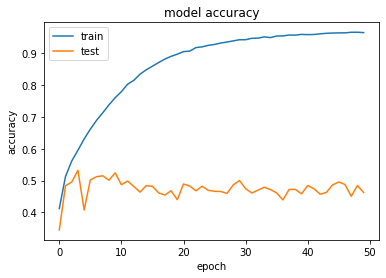

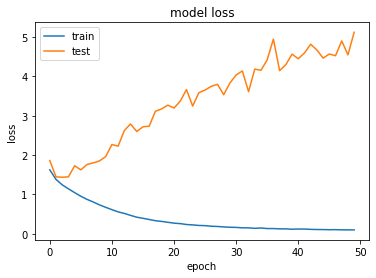

In [ ]:
show_summary_stats(history)

In [ ]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(4000,) (4000,)
               precision    recall  f1-score   support

   Electronic       0.42      0.56      0.48       500
 Experimental       0.35      0.50      0.41       500
         Folk       0.59      0.66      0.62       500
      Hip-Hop       0.67      0.48      0.56       500
 Instrumental       0.41      0.34      0.37       500
International       0.59      0.47      0.53       500
          Pop       0.15      0.14      0.15       500
         Rock       0.66      0.55      0.60       500

     accuracy                           0.46      4000
    macro avg       0.48      0.46      0.46      4000
 weighted avg       0.48      0.46      0.46      4000



In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.46275


### Look at the Test Set

In [ ]:
npzfile = np.load('../input/load-data1/test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [ ]:
from keras.models import load_model

weights_path = './weights.best.hdf5'
model = load_model(weights_path)

In [ ]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [ ]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000000000000016 0.004623813018385694


In [ ]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 128, 128, 1), found shape=(32, 640, 128, 1)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))